# Load the data

In [2]:
import os
import numpy as np
import random
import math
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
# import umap

In [3]:
X_ls = []
y_ls = []
DATA_DIR = "data/spectrogram_data/"
for x_file in sorted(os.listdir(DATA_DIR)):
    if "X" not in x_file:
        continue
    num_str = "".join([j for j in filter(str.isdigit, x_file)])
    X = np.load(DATA_DIR + x_file)
    y = np.load(f"{DATA_DIR}/sub-{num_str}_y.npy")
    assert X.shape[0] == y.shape[0]
    X_ls.append(X)
    y_ls.append(y)
    

# Set reference counts to 0 to try to reclaim space
X = np.concatenate(X_ls)
X_ls = None
y = np.concatenate(y_ls)
y_ls = None

X_mean = X.mean()
X_std = X.std()
X = (X - X_mean) / (X_std + 1e-8)
X_mean = None
X_std = None
print("Stacked shapes: ", X.shape, y.shape)

# Remove dementia patients
indicies = np.where(y!=2)[0]
y = y[indicies]
X = X[indicies]
Xshape = X.shape # When we want to reuse unflattened shape
print("Excluding dementia shapes: ", X.shape, y.shape)

# Flatten
X = X.reshape((X.shape[0], -1))
print("Flattened X shape: ", X.shape)
# Alzheimers = 1, Healthy = 0
print("Y counts: ", Counter(y))

# Split into Train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67, shuffle=True
)
print(f"Xtr: {X_train.shape}, ytr: {y_train.shape}, Xte: {X_test.shape}, yte: {y_test.shape}")

Stacked shapes:  (69705, 19, 33, 7) (69705,)
Excluding dementia shapes:  (45637, 19, 33, 7) (45637,)
Flattened X shape:  (45637, 4389)
Y counts:  Counter({np.int64(1): 29081, np.int64(0): 16556})
Xtr: (36509, 4389), ytr: (36509,), Xte: (9128, 4389), yte: (9128,)
Xtr: (36509, 4389), ytr: (36509,), Xte: (9128, 4389), yte: (9128,)


# Knn

In [9]:
# Square root method says let k = sqrt(N)//2
math.sqrt(X_train.shape[0]) // 2

95.0

In [11]:
# Generate Random Sampling from X and y
sampling_percentage = 0.5
indicies = random.sample(range(0, X_train.shape[0]), int(X_train.shape[0] * sampling_percentage))
print("Sampled label count: ", Counter(y_train[indicies]))

# Odd k so there is no tie
ks = [3, 5, 15, 31, 61, 91]
for k in ks:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train[indicies], y_train[indicies])
    print(f"k = {k}")
    print("Train Score: ", neigh.score(X_train, y_train))
    print("Test Score: ", neigh.score(X_test, y_test))

Sampled label count:  Counter({np.int64(1): 11692, np.int64(0): 6562})
k = 3


KeyboardInterrupt: 

# Visualization

In [ ]:
# TSNE
sampling_percentage = 0.4 # To reduce time and memory usage
indicies = random.sample(range(0, X_train.shape[0]), int(X_train.shape[0] * sampling_percentage))

perplexities = [5, 10, 15, 30, 50]
for perplexity in perplexities:
    X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity).fit_transform(X_train[indicies])
    alz_idx = np.where(y_train[indicies]==1)
    hea_idx = np.where(y_train[indicies]==0)
    plt.scatter(X_embedded[alz_idx, 0], X_embedded[alz_idx, 1], s=1, c="orange", label="Alzheimer")
    plt.scatter(X_embedded[hea_idx, 0], X_embedded[hea_idx, 1], s=1, c="blue", label="Healthy")
    plt.legend()
    plt.title(f"TSNE {sampling_percentage * 100}% of Training Data with P={perplexity}")
    plt.show()

In [ ]:
# UMAP
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_train)
alz_idx = np.where(y_train==1)
hea_idx = np.where(y_train==0)
plt.scatter(embedding[alz_idx, 0], embedding[alz_idx, 1], s=1, c="orange", label="Alzheimer")
plt.scatter(embedding[hea_idx, 0], embedding[hea_idx, 1], s=1, c="blue", label="Healthy")
plt.xlabel("UMAP component 0")
plt.ylabel("UMAP component 1")
plt.title(f"UMAP of Training Data")
plt.show()

# Clustering

In [4]:
# Kmeans
from sklearn.cluster import MiniBatchKMeans
ks = [3, 4, 8, 12, 16, 20, 30, 40, 80, 120, 160, 200, 300, 400]

print("Percent Alz: " + str(Counter(y_train)[1] / len(y_train)))
print()
mappings = []
for k in ks:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=67, batch_size=64, max_iter=300).fit(X_train)
    labels = kmeans.predict(X_train)
    print(f"----------- k={k} -----------")
    correct = 0
    total = 0
    mapping = dict()
    for c in range(k):
        idx = np.where(labels == c)
        yhat = y_train[idx]
        l = len(yhat)
        total += l

        # print((yhat==1).sum(), l)
        alz_percent = (yhat==1).sum()/l
        # print(f"Cluster {c}: ", "{:.5f}".format(alz_percent), "with Alz. Size =", len(yhat))
        
        if alz_percent >= 0.5:
            num_correct = (yhat==1).sum()
            mapping[c] = 1
        else:
            mapping[c] = 0
            num_correct = l - (yhat==1).sum()

        correct += num_correct
    mappings.append(mapping)
    print(f"Accuracy for k={k}: ", correct / total)
        

        
        # print(f"Cluster {c}: ", "{:.5f}".format((yhat==1).sum()/l), "with Alz. Size =", len(yhat))
        # print("Healthy: ", (yhat==0).sum()/l)
        # print("Alz: ", (yhat==1).sum()/l)
    print()



Percent Alz: 0.6383905338409707

----------- k=3 -----------
Accuracy for k=3:  0.6383905338409707

----------- k=3 -----------
Accuracy for k=3:  0.6383905338409707

----------- k=4 -----------
Accuracy for k=4:  0.6383905338409707

----------- k=4 -----------
Accuracy for k=4:  0.6383905338409707

----------- k=8 -----------
Accuracy for k=8:  0.6534005313758251

----------- k=8 -----------
Accuracy for k=8:  0.6534005313758251

----------- k=12 -----------
Accuracy for k=12:  0.6641923909173081

----------- k=12 -----------
Accuracy for k=12:  0.6641923909173081

----------- k=16 -----------
Accuracy for k=16:  0.6561121915144211

----------- k=16 -----------
Accuracy for k=16:  0.6561121915144211

----------- k=20 -----------
Accuracy for k=20:  0.6600290339368375

----------- k=20 -----------
Accuracy for k=20:  0.6600290339368375

----------- k=30 -----------
Accuracy for k=30:  0.6819962201101099

----------- k=30 -----------
Accuracy for k=30:  0.6819962201101099

----------- k

/var/folders/w1/x3w60pl13czc6qg2x7d0xstm0000gn/T/ipykernel_25128/1031476470.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alz_percent = (yhat==1).sum()/l


----------- k=120 -----------
Accuracy for k=120:  0.7392423785915802

----------- k=160 -----------
Accuracy for k=160:  0.6912268207839163

----------- k=160 -----------
Accuracy for k=160:  0.6912268207839163



/var/folders/w1/x3w60pl13czc6qg2x7d0xstm0000gn/T/ipykernel_25128/1031476470.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alz_percent = (yhat==1).sum()/l


----------- k=200 -----------
Accuracy for k=200:  0.719466432934345



/var/folders/w1/x3w60pl13czc6qg2x7d0xstm0000gn/T/ipykernel_25128/1031476470.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alz_percent = (yhat==1).sum()/l


----------- k=300 -----------
Accuracy for k=300:  0.7031964721027691



/var/folders/w1/x3w60pl13czc6qg2x7d0xstm0000gn/T/ipykernel_25128/1031476470.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alz_percent = (yhat==1).sum()/l


----------- k=400 -----------
Accuracy for k=400:  0.7006491550028761



/var/folders/w1/x3w60pl13czc6qg2x7d0xstm0000gn/T/ipykernel_25128/1031476470.py:22: RuntimeWarning: invalid value encountered in scalar divide
  alz_percent = (yhat==1).sum()/l


In [ ]:
# Gaussian Mixture Model
sampling_percentage = 0.2 # To reduce time and memory usage
indicies = random.sample(range(0, X_train.shape[0]), int(X_train.shape[0] * sampling_percentage))

gX = X_train[indicies]
gy = y_train[indicies]

ks = [2, 3, 5, 8]
for k in ks:
    labels = GaussianMixture(n_components=k, random_state=0).fit_predict(gX)
    k = max(labels)+1
    for c in range(k):
        idx = np.where(labels == c)
        yhat = gy[idx]
        l = len(yhat)
        print(f"Cluster {c}: ", "{:.5f}".format((yhat==1).sum()/l), "with Alz. Size =", len(yhat))
    print()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

labels = AgglomerativeClustering().fit_predict(X_train)
k = max(labels)+1
for c in range(k):
    idx = np.where(labels == c)
    yhat = y_train[idx]
    l = len(yhat)
    print(f"Cluster {c}: ", "{:.5f}".format((yhat==1).sum()/l), "with Alz. Size =", len(yhat))
print()

Percent Alz in dataset: 0.6383905338409707

----------- k=1 -----------
WSS Loss: 393.32
Cluster compositions (no forced mapping):
  Cluster 0: Size=36509 | Alz=23307 (63.8%) | Healthy=13202 (36.2%)

----------- k=1 -----------
WSS Loss: 393.32
Cluster compositions (no forced mapping):
  Cluster 0: Size=36509 | Alz=23307 (63.8%) | Healthy=13202 (36.2%)

----------- k=2 -----------
WSS Loss: 375.35
Cluster compositions (no forced mapping):
  Cluster 0: Size=2427 | Alz=1657 (68.3%) | Healthy= 770 (31.7%)
  Cluster 1: Size=34082 | Alz=21650 (63.5%) | Healthy=12432 (36.5%)

----------- k=2 -----------
WSS Loss: 375.35
Cluster compositions (no forced mapping):
  Cluster 0: Size=2427 | Alz=1657 (68.3%) | Healthy= 770 (31.7%)
  Cluster 1: Size=34082 | Alz=21650 (63.5%) | Healthy=12432 (36.5%)

----------- k=3 -----------
WSS Loss: 371.02
Cluster compositions (no forced mapping):
  Cluster 0: Size=6793 | Alz=4834 (71.2%) | Healthy=1959 (28.8%)
  Cluster 1: Size=1633 | Alz=1050 (64.3%) | Health

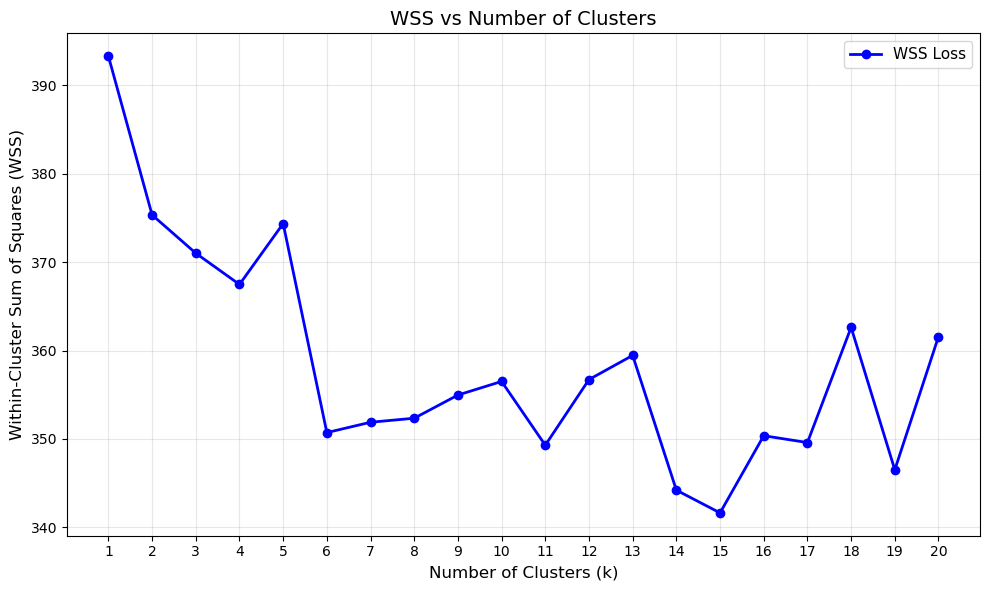


WSS computed for k in range(1,21). Elbow detection removed.


In [6]:
# Natural Clustering Analysis (WSS only)
from sklearn.cluster import MiniBatchKMeans
ks = list(range(1, 21))  # k from 1 to 20

print("Percent Alz in dataset: " + str(Counter(y_train)[1] / len(y_train)))
print()

wss_losses = []  # Within-cluster sum of squares

for k in ks:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=67, batch_size=64, max_iter=300).fit(X_train)
    labels = kmeans.predict(X_train)
    
    # Calculate WSS (inertia from kmeans)
    wss = kmeans.inertia_
    wss_losses.append(wss)
    
    print(f"----------- k={k} -----------")
    print(f"WSS Loss: {wss:.2f}")
    print(f"Cluster compositions (no forced mapping):")
    
    for c in range(k):
        idx = np.where(labels == c)
        yhat = y_train[idx]
        cluster_size = len(yhat)
        alz_count = (yhat==1).sum()
        healthy_count = (yhat==0).sum()
        alz_percent = alz_count / cluster_size if cluster_size > 0 else 0
        
        print(f"  Cluster {c}: Size={cluster_size:4d} | Alz={alz_count:4d} ({alz_percent:.1%}) | Healthy={healthy_count:4d} ({1-alz_percent:.1%})")
    print()

# Plot WSS loss (no elbow detection)
plt.figure(figsize=(10, 6))
plt.plot(ks, wss_losses, 'b-o', linewidth=2, markersize=6, label='WSS Loss')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WSS)', fontsize=12)
plt.title('WSS vs Number of Clusters', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(ks)
plt.tight_layout()
plt.show()

print('\n' + '='*50)
print('WSS computed for k in range(1,21). Elbow detection removed.')
print('='*50)


In [22]:
# Save clusters for k=6 into separate folders, grouping samples by patient
import os
import numpy as np
from sklearn.cluster import MiniBatchKMeans

# Configuration
k = 6
base_dir = 'data/clustered_k6'
os.makedirs(base_dir, exist_ok=True)
DATA_DIR = 'data/spectrogram_data/'

# Ensure the required variables are present in the notebook namespace
if 'X_train' not in globals() or 'y_train' not in globals():
    raise RuntimeError('X_train and y_train are required. Run the earlier cells that produce X_train/y_train before executing this cell.')

# Reconstruct subject mapping for the concatenated dataset so we can map each sample back to its patient
subject_ids_full = []
y_full_list = []
# We iterate files in the same sorted order used earlier when concatenating
for x_file in sorted(os.listdir(DATA_DIR)):
    if 'X' not in x_file:
        continue
    num_str = ''.join([j for j in filter(str.isdigit, x_file)])
    X_tmp = np.load(os.path.join(DATA_DIR, x_file), mmap_mode='r')
    n = X_tmp.shape[0]
    subject_ids_full.extend([num_str] * n)
    y_tmp = np.load(os.path.join(DATA_DIR, f'sub-{num_str}_y.npy'), mmap_mode='r')
    y_full_list.append(y_tmp)

subject_ids_full = np.array(subject_ids_full)
y_full = np.concatenate(y_full_list)

# Apply the same dementia filtering used earlier in this notebook (remove label 2)
filtered_idx = np.where(y_full != 2)[0]
subject_ids_filtered = subject_ids_full[filtered_idx]

# Verify lengths align with the full dataset (after filtering and flattening)
# `X_train` is only the training split — compare against the full `X` (the flattened, filtered dataset)
if 'X' in globals():
    full_n = X.shape[0]
elif 'y' in globals():
    full_n = y.shape[0]
else:
    raise RuntimeError('Full dataset variable `X` or `y` not found. Run preprocessing cells before this cell.')

if subject_ids_filtered.shape[0] != full_n:
    raise RuntimeError(f'Length mismatch: subject mapping ({subject_ids_filtered.shape[0]}) vs full dataset ({full_n}). Run the preprocessing cells in order before this cell.')

# Fit KMeans (MiniBatch) on the training data and assign cluster labels
kmeans = MiniBatchKMeans(n_clusters=k, random_state=67, batch_size=64, max_iter=300).fit(X_train)
labels = kmeans.predict(X_train)

# For each cluster, create a folder and then save per-patient files (one .npy per patient)
for c in range(k):
    cluster_dir = os.path.join(base_dir, f'cluster_{c}')
    os.makedirs(cluster_dir, exist_ok=True)

    idx = np.where(labels == c)[0]
    if len(idx) == 0:
        print(f'Cluster {c} is empty, skipping')
        continue

    # Determine which patients appear in this cluster
    patients = np.unique(subject_ids_filtered[idx])
    print(f'Cluster {c}: {len(idx)} samples across {len(patients)} patients')

    # Save per-patient files directly inside the cluster folder (no subdirectories)
    for pid in patients:
        # indices of samples in X_train that belong to this patient and cluster
        mask = (subject_ids_filtered[idx] == pid)
        sample_indices = idx[mask]
        Xp = X_train[sample_indices]
        yp = y_train[sample_indices]
        # Save using the same filename pattern as the original data (per-patient), placed in the cluster folder
        x_fname = os.path.join(cluster_dir, f'sub-{pid}_X.npy')
        y_fname = os.path.join(cluster_dir, f'sub-{pid}_y.npy')
        idx_fname = os.path.join(cluster_dir, f'sub-{pid}_indices.npy')
        np.save(x_fname, Xp)
        np.save(y_fname, yp)
        np.save(idx_fname, sample_indices)
        print(f'  Saved patient sub-{pid}: {len(sample_indices)} samples -> {cluster_dir}')

print('All clusters (grouped by patient) saved under: ' + base_dir)


Cluster 0: 3850 samples across 47 patients
  Saved patient sub-001: 68 samples -> data/clustered_k6/cluster_0
  Saved patient sub-002: 76 samples -> data/clustered_k6/cluster_0
  Saved patient sub-003: 38 samples -> data/clustered_k6/cluster_0
  Saved patient sub-004: 96 samples -> data/clustered_k6/cluster_0
  Saved patient sub-005: 86 samples -> data/clustered_k6/cluster_0
  Saved patient sub-006: 66 samples -> data/clustered_k6/cluster_0
  Saved patient sub-007: 86 samples -> data/clustered_k6/cluster_0
  Saved patient sub-008: 80 samples -> data/clustered_k6/cluster_0
  Saved patient sub-009: 58 samples -> data/clustered_k6/cluster_0
  Saved patient sub-010: 162 samples -> data/clustered_k6/cluster_0
  Saved patient sub-011: 87 samples -> data/clustered_k6/cluster_0
  Saved patient sub-012: 118 samples -> data/clustered_k6/cluster_0
  Saved patient sub-013: 93 samples -> data/clustered_k6/cluster_0
  Saved patient sub-014: 89 samples -> data/clustered_k6/cluster_0
  Saved patient s